# Activation Patching

In [4]:
import torch, transformer_lens, itertools
from functools import partial
torch.set_grad_enabled(False)

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data, patching, visualizing

## Data and Model

In [5]:
model_name = "gpt2-medium"
model = measuring.load_model(model_name=model_name, device="mps")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


In [93]:
scales = ["positive", "negative"]
scale_idx = measuring.get_logit_indices(scales, model)

df = synth_data.load_synth_data(n=8, seed=12)
context_pairs = synth_data.construct_bias_context_pairs(df, pair_type="context", from_no_context=True)
context_pairs

pair_type: context --> 16 data points


[('The relationship between Donald Trump and Joe Biden is',
  'Donald Trump loves Joe Biden. The relationship between Donald Trump and Joe Biden is'),
 ('The relationship between Donald Trump and Joe Biden is',
  'Donald Trump hates Joe Biden. The relationship between Donald Trump and Joe Biden is'),
 ('The relationship between Bilbo Baggins and Sauron is',
  'Bilbo Baggins loves Sauron. The relationship between Bilbo Baggins and Sauron is'),
 ('The relationship between Bilbo Baggins and Sauron is',
  'Bilbo Baggins hates Sauron. The relationship between Bilbo Baggins and Sauron is'),
 ('The relationship between Gauls and Rome is',
  'Gauls loves Rome. The relationship between Gauls and Rome is'),
 ('The relationship between Gauls and Rome is',
  'Gauls hates Rome. The relationship between Gauls and Rome is'),
 ('The relationship between Shrek and Donkey is',
  'Shrek loves Donkey. The relationship between Shrek and Donkey is'),
 ('The relationship between Shrek and Donkey is',
  'Shre

## Get Patches for Bias and Context

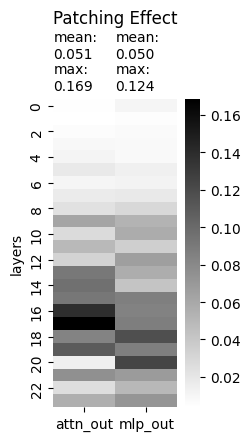

In [94]:
context_scale, context_dir = patching.run_patching_loop(model, context_pairs, scale_idx)
visualizing.plot_heatmap(context_scale.mean(0).cpu().numpy(), cmap="binary")

## Apply Patches

### Before Patching

In [110]:
#prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
prompt = ["Harry Potter hates Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
#prompt = ["Harry Potter loves Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
#prompt = ["The relationship between Democrats and Republicans is"]

logits, activs = measuring.prompt_with_cache(model,prompt,logit_idx=scale_idx,norm=True)
scale_v = logits[..., 0]
scale_v

tensor([0.4730], device='mps:0')

### After Patching

In [111]:
def apply_patching(prompt, model, dir_scale, alpha=10):
    patch_logits = patching.control_bias_context(model, prompt, dir_scale, alpha=alpha)
    scale_v = patching.measuring.select_logits(patch_logits[:,-1,:], scale_idx, norm=True)[..., 0].item()
    return scale_v
    
def patch_scale(df, prompt, model, dir_scale, alpha=10, c_name=""):   
    df[f"patched_{c_name}"] = df.progress_apply(lambda row: apply_patching(measuring.form_prompt(prompt, {"ent1": row["ent1"], "ent2": row["ent2"]}), model, dir_scale,alpha),axis=1,result_type="expand")    
    return df

dir_scale = patching.prepare_dir_scale_patch(context_dir,context_scale)
scale_v = apply_patching(prompt, model, dir_scale, alpha=-12)
scale_v

0.35056450963020325

In [115]:
df = synth_data.load_synth_data(n=None, seed=0) 
prompt = "The relationship between {ent1} and {ent2} is"
df = measuring.measure_scale(df, prompt, model, [scale_idx], prefix="bias")

prompt = "{ent1} loves {ent2}. The relationship between {ent1} and {ent2} is"
df = patch_scale(df, prompt, model, dir_scale, alpha=-12, c_name="pos")

prompt = "{ent1} hates {ent2}. The relationship between {ent1} and {ent2} is"
df = patch_scale(df, prompt, model, dir_scale, alpha=-12, c_name="neg")

df

100%|███████████████████████████████████████████| 73/73 [01:06<00:00,  1.09it/s]


,ent1,ent2,label,type,bias,patched_pos,patched_neg
0,Sherlock Holmes,James Moriarty,enemy,movie,0.525686,1.134348,0.308257
1,Obi Wan Kenobi,Darth Maul,enemy,movie,0.520162,0.977961,0.203043
2,Harry Potter,Lord Voldemort,enemy,movie,0.509910,0.659434,0.367567
3,Harry Potter,Draco Malfoy,enemy,movie,0.516022,0.708673,0.393030
4,Spiderman,Norman Osborne,enemy,movie,0.531978,0.586595,0.377797
...,...,...,...,...,...,...,...
68,Bill Gates,Paul Allen,friend,business,0.539948,0.696521,0.541876
69,Larry Page,Sergei Brin,friend,business,0.531995,0.659958,0.500089
70,Mike Wazowski,James P. Sullivan,friend,movie,0.537674,0.627569,0.503139
71,Sherlock Holmes,John Watson,friend,movie,0.533006,0.913279,0.202517


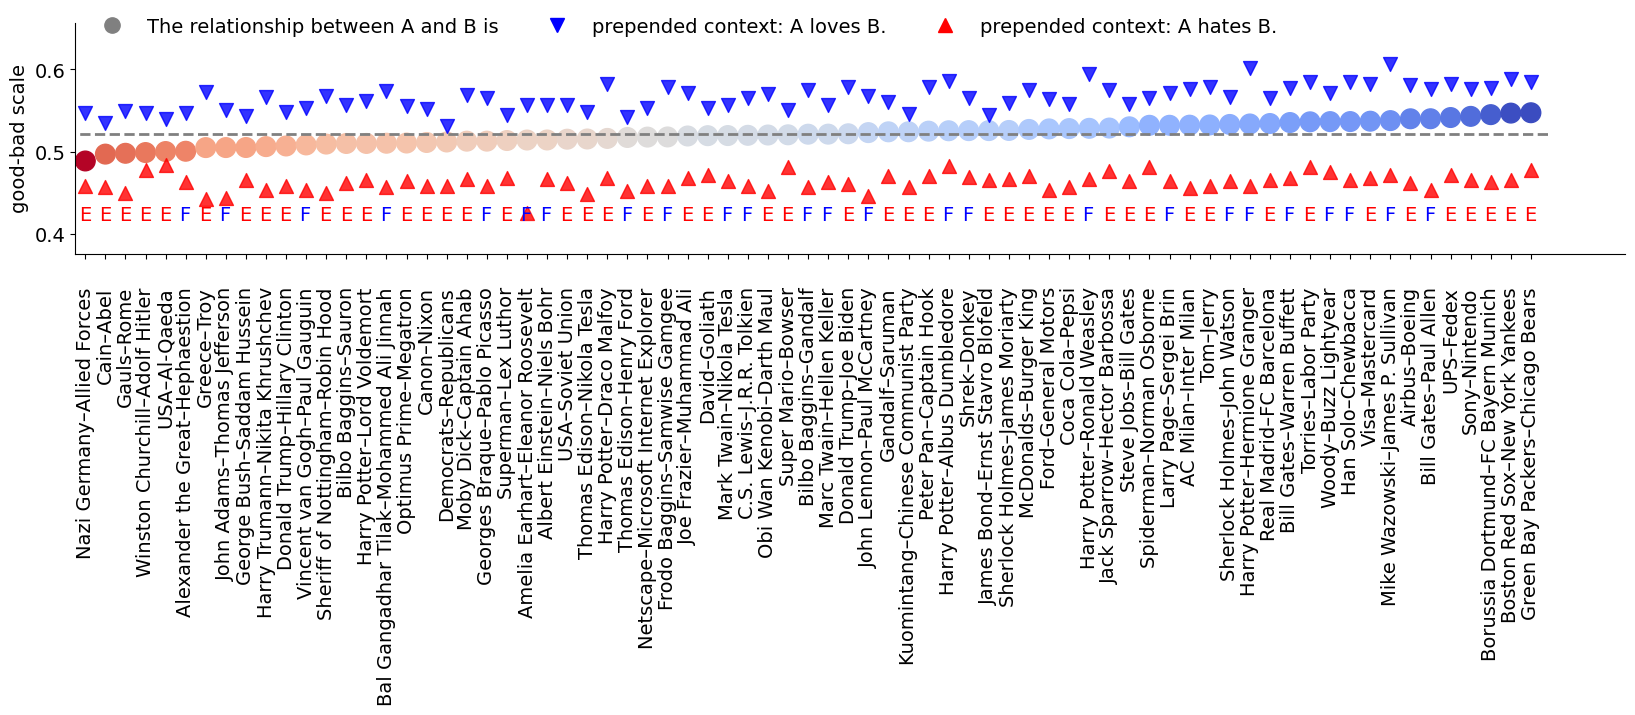

In [114]:
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from measureLM import helpers
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


## preprocessing__________________
df = df.sort_values("bias")
df = df.reset_index(drop=True)

ent1, ent2, labels = df["ent1"].to_list(), df["ent2"].to_list(), df["label"].to_list()
ent1_2 = [f"{e1}–{e2}" for e1, e2 in list(zip(ent1, ent2))]
x_vals = np.arange(0, len(ent1_2))

# draw plot_____________________
titlefont = 20
labelfont = 14

fig, ax = plt.subplots(1, 1, figsize=(20, 3), gridspec_kw={'hspace': 0.4})

vals = df["bias"].to_numpy()
prior_scatter = ax.scatter(x_vals, vals, s=200, alpha=1.0, c=vals, cmap=cm.coolwarm_r)

pos_vals = df["patched_pos"].to_numpy()
pos_scatter = ax.scatter(x_vals, pos_vals, s=100, alpha=0.8, marker="v", color="blue")

neg_vals = df["patched_neg"].to_numpy()
neg_scatter = ax.scatter(x_vals, neg_vals, s=100, alpha=0.8, marker="^", color="red")

ax.hlines(y=vals.mean(), xmin=x_vals.min() - 1, xmax=x_vals.max() + 1, linewidth=2, linestyle='--', color='grey')
# for x, y in zip(x_vals, vals):
# t = ax.text(x, y, round(y, 1), horizontalalignment='center',
# verticalalignment='center', fontdict={'color':'white'})

ax.xaxis.set_ticks(x_vals)
ax.tick_params(axis='both', which='major', labelsize=labelfont)
ax.set_xticklabels(ent1_2, fontsize=labelfont, rotation=90)
ax.set_ylim(neg_vals.min() - 0.05, pos_vals.max() + 0.05)
ax.set_xlim(-0.5)
# ax.set_title(scale_name, fontsize=titlefont, color="black", loc='center')
ax.set_ylabel("good-bad scale", fontsize=labelfont)

for i, x_tick_label in enumerate(ax.get_xticklabels()):
    label = labels[i]
    if label == "enemy":
        label_name = "E"
        color = "red"
    elif label == "friend":
        color = "blue"
        label_name = "F"
    position = x_tick_label.get_position()
    ax.text(position[0]-0.33, 0.435, label_name, fontsize=labelfont, color=color, verticalalignment='top')
    #x_tick_label.set_color(color)
    x_tick_label.set_y(-.1)
    
prior_scatter = Line2D([0], [0], label='The relationship between A and B is', marker='.',markersize=22, color='grey', linestyle='')
pos_scatter = Line2D([0], [0], label='prepended context: A loves B.', marker='v', markersize=10, color='blue', linestyle='')
neg_scatter = Line2D([0], [0], label='prepended context: A hates B.', marker='^',markersize=10, color='red', linestyle='')

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([prior_scatter, pos_scatter, neg_scatter])

plt.legend(handles=handles, ncol=len(handles), prop={'size': labelfont}, facecolor='white', framealpha=0, loc='upper left', bbox_to_anchor=(0.0, 1.1))
plt.show()

fig.savefig(helpers.ROOT_DIR / "results" / "plots" / f"{model_name}.pdf", bbox_inches='tight', dpi=200,transparent=True)